# Iterative $\alpha$-(de)blending
--------------------------------------
    Alfred PICHARD

## Table of Contents :
### 1. Sinusoidal Positional Encoding
      Implementation of the encoder and plot results
### 2. Diffusion for a 2D point cloud inference problem
      2.1 Simple MLP
      2.2 UNet MLP

In [626]:
### IMOPRTS
%matplotlib inline
from PIL import Image
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
plt.style.use('dark_background')

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim

device = "cpu"

## 1. Sinusoidal Positional Encoding

In [627]:
class PositionalEncoder(nn.Module):
    def __init__(self, pos_encoder_dim, max_length=10000):
        super().__init__()
        self.pos_encoder_dim = pos_encoder_dim
        self.max_length = max_length
        self.omega = torch.exp((torch.arange(0, self.pos_encoder_dim, 2, dtype=torch.float) * -(np.log(500.0) / self.pos_encoder_dim)))

    def forward(self, x):
        pe = torch.zeros(min(x.size(0), self.max_length), self.pos_encoder_dim)
        pe[:, 0::2] = torch.sin(x * self.omega)
        pe[:, 1::2] = torch.cos(x * self.omega)
        pe = pe[:x.size(0)]
        
        return pe

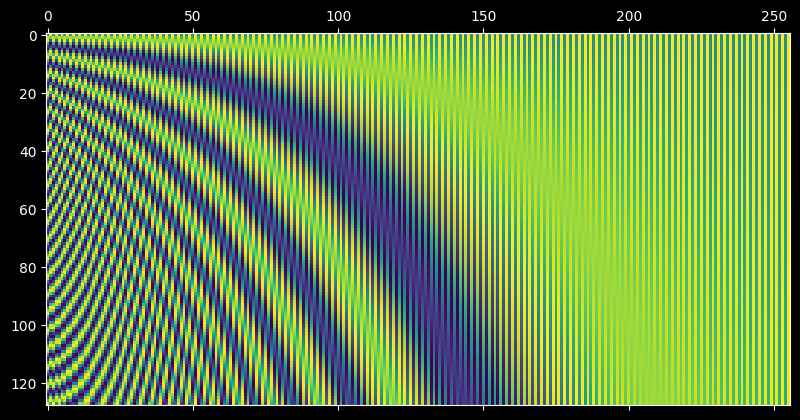

In [628]:
positional_encoder = PositionalEncoder(pos_encoder_dim=256)
tensor = torch.arange(128).unsqueeze(-1)
output = positional_encoder(tensor)
plt.matshow(output)


## 2. Diffusion for a 2D point cloud inference problem

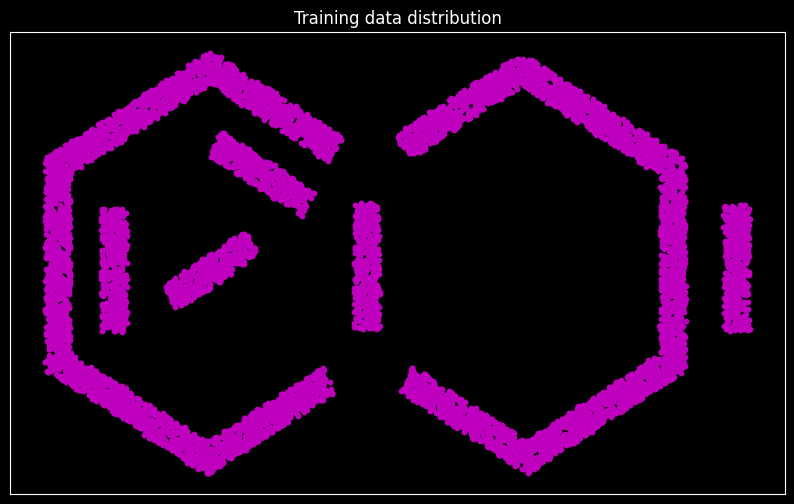

In [629]:
### Data preprocessing
def get_dataset(N=50000):
    img = mpimg.imread("../../resources/datasets/images/acids.png")

    img = (img * 255).astype(np.uint8)

    img = Image.fromarray(img).convert('L')
    gray_array = np.asarray(img)

    positions = np.random.rand(2, N)
    closest_idx = positions.copy()
    closest_idx[0] *= gray_array.shape[0]
    closest_idx[1] *= gray_array.shape[1]
    closest_idx = closest_idx.astype(int)
    density = np.zeros((N))

    for i in range(N):
        p1 = closest_idx[:, i]
        density[i] = (gray_array[459-p1[1], p1[0]] - 105)/138


    probs = np.random.rand(N)
    positions_final = positions[:,probs>density]    
    return torch.from_numpy(positions_final.T).float()*10-5


data = get_dataset(128000)

plt.figure(figsize=(10, 6))
plt.scatter(data.T[0], data.T[1], c='m', s=10)
plt.title("Training data distribution")
plt.xticks([])
plt.yticks([])
plt.show()

In [630]:
### Training loop for alpha-(de)blending which can be used on all 2D point cloud generation models
def train(model, optimizer, criterion, dataset, batch_size):
    epoch_loss = []
    permutation = torch.randperm(dataset.size()[0], device=device)
    noise_data = torch.randn_like(dataset)*0.5
    
    for i in range(0, dataset.size()[0], batch_size):     
        indices = permutation[i:min(dataset.size()[0], i+batch_size)]   
        x_1 = dataset[indices]
        x_0 = noise_data[indices]
        
        alpha = torch.rand(x_1.size()[0], 1, device=device)
        x_alpha = (1-alpha) * x_0 + alpha * x_1

        output = model(x_alpha, alpha)
        target = x_1 - x_0
        
        optimizer.zero_grad()
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        epoch_loss.append(loss.item())

    return np.mean(epoch_loss)

### 1.1 Simple MLP

In [631]:
### Modules Definition
class LinearBlock(nn.Module):
    def __init__(self, hidden_dim, pos_encoder_dim, block_size):
        super().__init__()
        self.dense_hidden = [nn.Linear(hidden_dim + pos_encoder_dim, hidden_dim) for _ in range(block_size)]
        self.activation = nn.SiLU()
    
    def forward(self, x, alpha):
        for layer in self.dense_hidden:
            x = self.activation(layer(torch.cat((x, alpha), dim=1)))
        return x


class AlphaDeblendMLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, pos_encoder_dim):
        super().__init__()
        self.input = nn.Linear(input_dim + pos_encoder_dim, hidden_dim)
        self.linear_block = LinearBlock(hidden_dim, pos_encoder_dim, block_size=3)
        self.output = nn.Linear(hidden_dim + pos_encoder_dim, input_dim)

        self.positional_encoder = PositionalEncoder(pos_encoder_dim=pos_encoder_dim)
        self.activation = nn.SiLU()
    
    def forward(self, x, alpha):
        alpha = self.positional_encoder(alpha).to(torch.float32)

        x = self.activation(self.input(torch.cat((x, alpha), dim=1)))
        x = self.linear_block(x, alpha)
        out = self.output(torch.cat((x, alpha), dim=-1))

        return out


In [632]:
BATCH_SIZE = 64
EPOCHS = 10001
LR = 1e-3

model = AlphaDeblendMLP(input_dim=2, hidden_dim=128, pos_encoder_dim=64)
optimizer = optim.Adam(model.parameters(), lr=LR)
criterion = nn.MSELoss(reduction='mean')

### Train
for epoch in range(EPOCHS):
    epoch_loss = train(model, optimizer, criterion, data, BATCH_SIZE)

    if (epoch % 1000 == 0):
        print(f"Loss at epoch {epoch}: {epoch_loss}")

Loss at epoch 0: 4.5574356270463845
Loss at epoch 1000: 1.4367951013539966
Loss at epoch 2000: 1.4285263093678575
Loss at epoch 3000: 1.4489447329389422
Loss at epoch 4000: 1.4394463520301015
Loss at epoch 5000: 1.428952039072388
Loss at epoch 6000: 1.4516904295275086
Loss at epoch 7000: 1.4570702188893367
Loss at epoch 8000: 1.4409766256024963
Loss at epoch 9000: 1.4262987861507817
Loss at epoch 10000: 1.4437232625327612


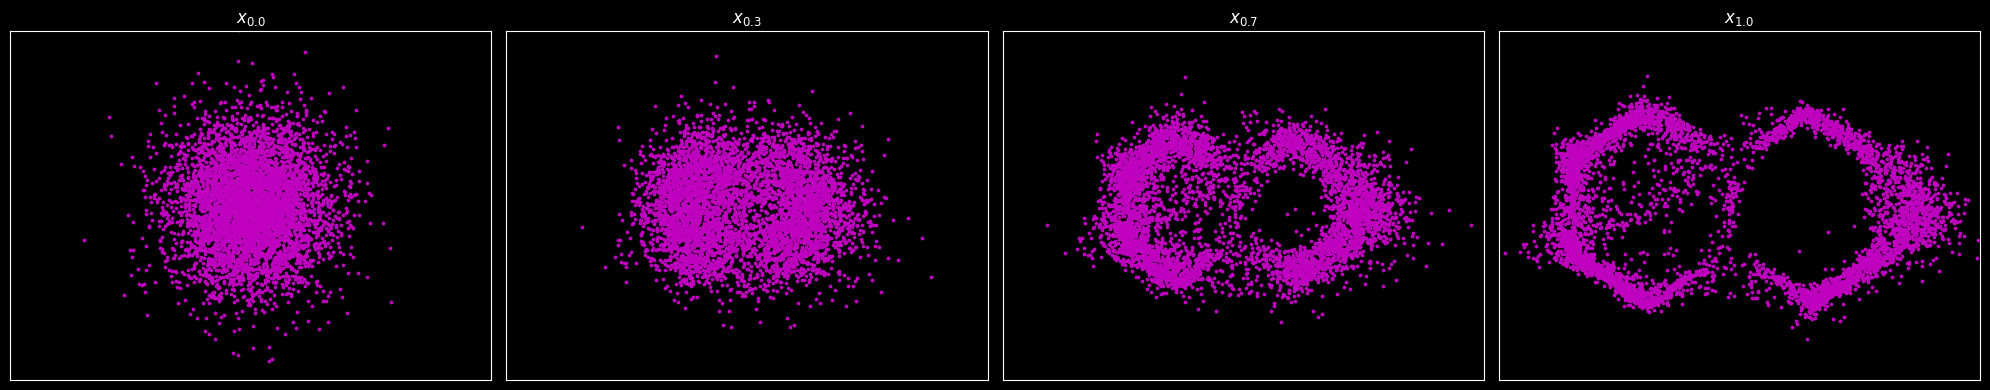

In [633]:
NUM_PLOTS = 3
BATCH_SIZE = 5000
fig, axs = plt.subplots(1, NUM_PLOTS+1, figsize=(20,4))

with torch.no_grad():
    x_alpha = torch.randn(BATCH_SIZE, 2, device=device)

    T = 100
    for t in range(T+1):
        alpha = t/T * torch.ones(BATCH_SIZE, 1)
        x_alpha = x_alpha + (1/T)*model(x_alpha, alpha)

        if (t % (T//NUM_PLOTS) == 0):
            i = t//(T//NUM_PLOTS)
            axs[i].scatter(x_alpha.T[0], x_alpha.T[1], c='m', s=3)
            axs[i].set_title(f"$x_{{{'%.1f'%(alpha[0])}}}$")
            axs[i].set_xlim([-6, 6])
            axs[i].set_ylim([-4, 4])
            axs[i].set_yticks([])
            axs[i].set_xticks([])

    fig.tight_layout()
    plt.show()

### 2.2 UNET MLP

In [634]:
### Modules
class Resample(nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()
        self.resample = nn.Linear(input_dim, output_dim)
        self.activation = nn.SiLU()

    def forward(self, x):
        return self.activation(self.resample(x))


class LinearEncoder(nn.Module):
    def __init__(self, hidden_dims, block_sizes, pos_encoder_dim):
        super().__init__()
        """
        Example with: hidden_dims = [64, 32, 16, 8] & block_sizes = [2, 2, 2]
        linear(64, 64) (x2)
        linear(64, 32)
        linear(32, 32) (x2)
        linear(32, 16)
        linear(16, 16) (x2)
        linear(16, 8)
        """
        self.blocks = [LinearBlock(hidden_dims[k], pos_encoder_dim, block_sizes[k]) for k in range(len(hidden_dims)-1)]
        self.downsamples = [Resample(hidden_dims[k-1], hidden_dims[k]) for k in range(1, len(hidden_dims))]

        self.activation = nn.SiLU()

    def forward(self, x, alpha):
        residuals = []
        for block_id in range(len(self.blocks)):
            x = self.blocks[block_id](x, alpha)
            residuals.append(x)
            x = self.activation(self.downsamples[block_id](x))
        return x, residuals


class LinearDecoder(nn.Module):
    def __init__(self, hidden_dims, block_sizes, pos_encoder_dim):
        super().__init__()
        """
        Example with: hidden_dims = [16, 32, 64], resample_out_dims = [16, 64, 512] & block_sizes = [2, 2, 2]
        upsample : linear(8, 16)
        block : linear(16, 16) (x2)
        cat with residual(16) : result dim (32)

        block : linear(32, 32) (x2)
        cat with residual(32) : result dim (64)

        block : linear(64, 64) (x2)
        cat with residual(64) : result dim (128)
        """
        self.blocks = [LinearBlock(hidden_dims[k], pos_encoder_dim, block_sizes[k-1]) for k in range(len(hidden_dims))]
        self.upsample = Resample(8, 16)

        self.activation = nn.SiLU()

    def forward(self, x, alpha, residuals):
        x = self.activation(self.upsample(x))
        for block_id in range(len(self.blocks)):
            residual = residuals.pop()
            x = torch.cat((self.blocks[block_id](x, alpha), residual), dim=1)

        return x

In [635]:
### UNet
class LinearUNet(nn.Module):
    def __init__(self, input_dim, pos_encoder_dim):
        super().__init__()
        # Input and Output
        self.input = nn.Linear(input_dim+pos_encoder_dim, 64)
        self.output = nn.Linear(128+pos_encoder_dim, 2)

        # Encoder
        self.encoder = LinearEncoder(
            hidden_dims=[64, 32, 16, 8],
            block_sizes=[2, 2, 2],
            pos_encoder_dim=pos_encoder_dim
        )

        # Bottom
        self.bottom = LinearBlock(
            hidden_dim=8,
            pos_encoder_dim=pos_encoder_dim,
            block_size=4
        )

        # Decoder
        self.decoder = LinearDecoder(
            hidden_dims=[16, 32, 64],
            block_sizes=[2, 2, 2],
            pos_encoder_dim=pos_encoder_dim
        )
        
        self.positional_encoder = PositionalEncoder(pos_encoder_dim=pos_encoder_dim)
        self.activation = nn.SiLU()
    
    def forward(self, x, alpha):
        alpha = self.positional_encoder(alpha).float()

        x = self.activation(self.input(torch.cat((x, alpha), dim=1)))
        
        x, residuals = self.encoder(x, alpha)
        x = self.bottom(x, alpha)
        x = self.decoder(x, alpha, residuals)

        out = self.output(torch.cat((x, alpha), dim=1))

        return out

In [636]:
BATCH_SIZE = 64
EPOCHS = 10001
LR = 1e-3

model = LinearUNet(input_dim=2, pos_encoder_dim=64)
optimizer = optim.Adam(model.parameters(), lr=LR)
dataset = data
criterion = nn.MSELoss(reduction='mean')

### Train
for epoch in range(EPOCHS):
    epoch_loss = train(model, optimizer, criterion, dataset, BATCH_SIZE)

    if (epoch % 1000 == 0):
        print(f"Loss at epoch {epoch}: {epoch_loss}")

Loss at epoch 0: 4.440285756399757
Loss at epoch 1000: 1.4477020106033276
Loss at epoch 2000: 1.460408717786011
Loss at epoch 3000: 1.4391978006613881
Loss at epoch 4000: 1.4201653748750687
Loss at epoch 5000: 1.440088614821434
Loss at epoch 6000: 1.4669087521339719
Loss at epoch 7000: 1.4337884979812723
Loss at epoch 8000: 1.4149995238373154
Loss at epoch 9000: 1.4430425531770055
Loss at epoch 10000: 1.4350909273091115


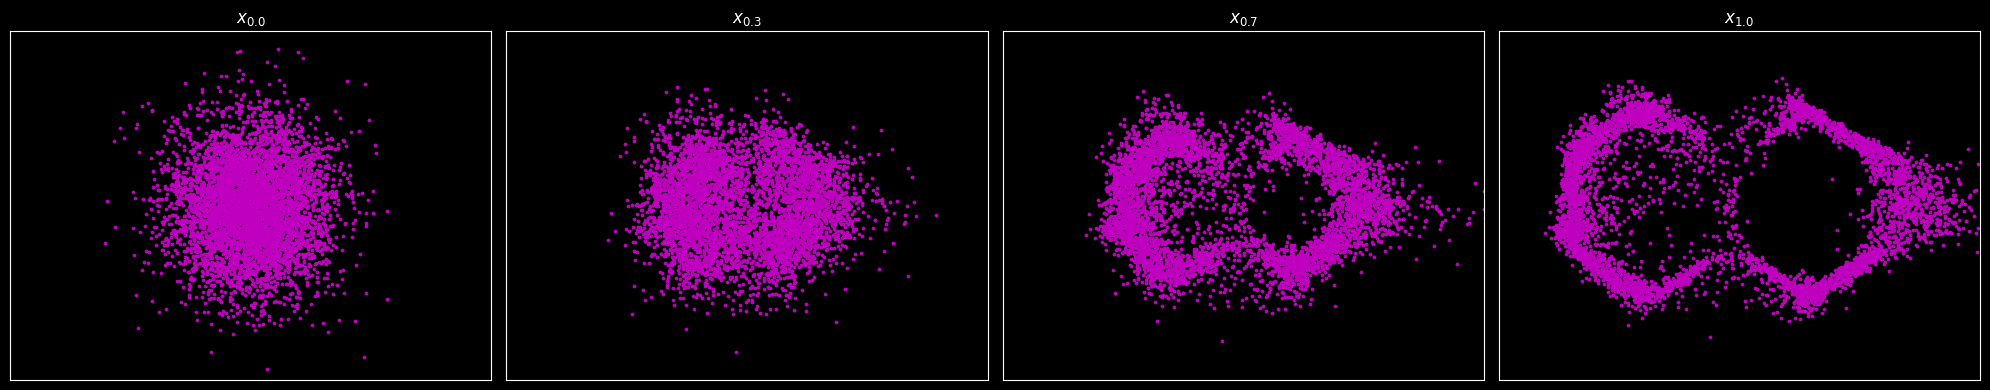

In [637]:
NUM_PLOTS = 3
BATCH_SIZE = 5000
fig, axs = plt.subplots(1, NUM_PLOTS+1, figsize=(20,4))

with torch.no_grad():
    x_alpha = torch.randn(BATCH_SIZE, 2, device=device)

    T = 100
    for t in range(T+1):
        alpha = t/T * torch.ones(BATCH_SIZE, 1)
        x_alpha = x_alpha + (1/T) * model(x_alpha, alpha)

        # Visualize
        if (t % (T//NUM_PLOTS) == 0):
            i = t//(T//NUM_PLOTS)
            axs[i].scatter(x_alpha.T[0], x_alpha.T[1], c='m', s=3)
            axs[i].set_title(f"$x_{{{'%.1f'%(alpha[0])}}}$")
            axs[i].set_xlim([-6, 6])
            axs[i].set_ylim([-4, 4])
            axs[i].set_yticks([])
            axs[i].set_xticks([])
    fig.tight_layout()
    plt.show()

## References
- Eric Heitz, Laurent Belcour, and Thomas Chambon. Iterative alpha-(de) blending: a minimalist
deterministic diffusion model. https://arxiv.org/pdf/2305.03486.pdf
- Olaf Ronneberger, Philipp Fischer, and Thomas Brox. U-net: Convolutional networks
for biomedical image segmentation. https://arxiv.org/pdf/1505.04597.pdf